### VGG -16:

- You’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew
Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet.
- Other models include —VGG, ResNet, Inception, Inception-ResNet, Xception, and so on...

### Feature extraction:

- Feature extraction consists of using the representations learned by a previous network
to extract interesting features from new samples. These features are then run through
a new classifier, which is trained from scratch.
- . In the
case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

The VGG16 model, among others, comes prepackaged with Keras. You can import
it from the keras.applications module. Here’s the list of image-classification
models (all pretrained on the ImageNet dataset) that are available as part of keras
.applications:
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

Let’s instantiate the VGG16 model.

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

In [8]:
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 10s 0us/step


In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Finally, we have 4* 4 * 512 feature map.

#### Two ways to go now:

- Running the convolutional base over your dataset, recording its output to a
Numpy array on disk, and then using this data as input to a standalone, densely
connected classifier.k. This solution
is fast and cheap to run, because it only requires running the convolutional
base once for every input image. But for the same reason, this technique won’t
allow you to use data augmentation.


- Extending the model you have (conv_base) by adding Dense layers on top, and
running the whole thing end to end on the input data. This will allow you to use
data augmentation, because every input image goes through the convolutional
base every time it’s seen by the model. But for the same reason, this technique is
far more expensive than the first.

#### 1. FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION:

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_dir = 'dataset/training_set'
test_dir = 'dataset/test_set'

In [19]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [27]:
def extract_features(direc,samples):
    features = np.zeros(shape=(samples,4,4,512)) #we need features of train and test set (all examples) after passing thru conv_base
    labels = np.zeros(shape= (samples))
    generator = datagen.flow_from_directory( #extracts images from train and test sets size 150 and sends as input to conv_base
    direc,
    target_size = (150,150),
    batch_size = batch_size,
    class_mode = 'binary')
    i = 0
    for input_batch,labels_batch in generator:
        features_batch = conv_base.predict(input_batch) #CONV_BASE PREDICTIONS
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i * batch_size >= samples:
            break
    return features,labels

In [28]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 8000 images belonging to 2 classes.


In [29]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


. You’ll feed them
to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [30]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

#### Defining and training the densely connected classifier:

In [86]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers


In [87]:
model = models.Sequential()

In [88]:
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))

In [89]:
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [90]:
#optimizer:
opt = keras.optimizers.RMSprop(learning_rate=2e-5)

In [91]:
model.compile(optimizer = opt,
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [92]:
history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(test_features, test_labels))

Epoch 1/30
100/100 [==============================] - 4s 35ms/step - loss: 0.5580 - acc: 0.7125 - val_loss: 0.4501 - val_acc: 0.8160
Epoch 2/30
100/100 [==============================] - 4s 35ms/step - loss: 0.4122 - acc: 0.8180 - val_loss: 0.3700 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 3s 31ms/step - loss: 0.3494 - acc: 0.8550 - val_loss: 0.3355 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 3s 30ms/step - loss: 0.3128 - acc: 0.8675 - val_loss: 0.3197 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 0.2863 - acc: 0.8805 - val_loss: 0.3100 - val_acc: 0.8690
Epoch 6/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2639 - acc: 0.8840 - val_loss: 0.2977 - val_acc: 0.8740
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 0.2565 - acc: 0.8960 - val_loss: 0.2916 - val_acc: 0.8700
Epoch 8/30
100/100 [==============================] - 3s 30ms/step - 

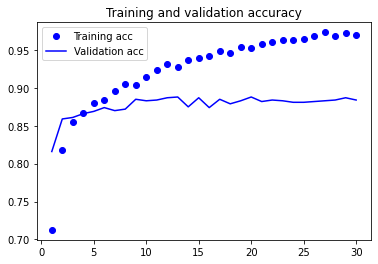

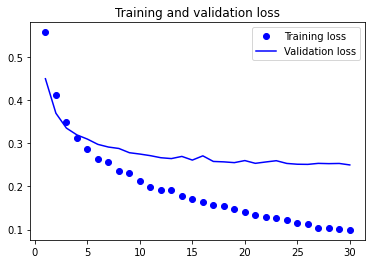

In [93]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

But the plots also indicate
that you’re overfitting almost from the start—despite using dropout with a fairly large
rate. That’s because this technique doesn’t use data augmentation, which is essential
for preventing overfitting with small image datasets. 